# Likelihood-free inference using Bayesian neural network 

In [1]:
from sciope.models.bnn_classifier import BNNModel
from sciope.utilities.priors.uniform_prior import UniformPrior
import numpy as np
import matplotlib.pyplot as plt

## MA2 Simulator

In [55]:
def simulator(param, n=100):
    """
    Simulate a given parameter combination.

    Parameters
    ----------
    param : vector or 1D array
        Parameters to simulate (\theta).
    n : integer
        Time series length
    """
    m = len(param)
    g = np.random.normal(0, 1, n)
    gy = np.random.normal(0, 0.3, n)
    y = np.zeros(n)
    x = np.zeros(n)
    for t in range(0, n):
        x[t] += g[t]
        for p in range(0, np.minimum(t, m)):
            x[t] += g[t - 1 - p] * param[p]
        y[t] = x[t] + gy[t]
    
    return np.reshape(y, (1,1,100))

## Create synthetic data

In [56]:
obs_data = simulator([0.6,0.2]) 

In [57]:
obs_data = np.transpose(obs_data, (0,2,1))

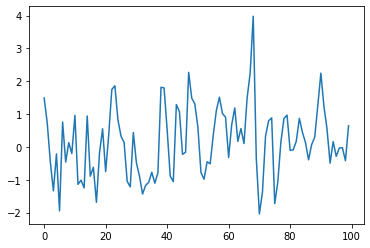

In [125]:
plt.plot(obs_data[0])

## Define initial prior

In [104]:
parameter_names = ['k1', 'k2']

lower_bounds = [-2, -1]
upper_bounds = [2, 1]

prior = UniformPrior(np.array(lower_bounds), np.array(upper_bounds))

## Perform parameter inference using BNN

In [162]:
from sciope.inference.bnn_inference import BNN

bnn = BNN(obs_data, simulator, prior, num_bins=4)

In [163]:
post = bnn.infer(num_samples=3000, num_rounds=6, chunk_size=10)

Epoch 00069: early stopping
Epoch 00100: early stopping
Epoch 00067: early stopping
Epoch 00068: early stopping
Epoch 00062: early stopping
Epoch 00067: early stopping


In [135]:
import matplotlib.pyplot as plt

def plot_posterior(posterior):
    true_params = [0.6, 0.2]
    fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1], facecolor = 'w')
    for i in range(posterior.shape[1]):
        for j in range(posterior.shape[1]):
            if i > j:
                ax[i,j].axis('off')
            else:
                if i == j:
                    ax[i,j].hist(posterior[:,i], bins = 'auto')
                    ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                    ax[i,j].axvline(true_params[i])
                    ax[i,j].set_xlim(lower_bounds[i], upper_bounds[i])
                else:
                    ax[i,j].scatter(posterior[:,j], posterior[:,i])
                    ax[i,j].scatter(true_params[j], true_params[i], c='red')
                    ax[i,j].set_ylim(lower_bounds[i], upper_bounds[i])
                    ax[i,j].set_xlim(lower_bounds[j], upper_bounds[j])
    fig.set_size_inches(10,10)
    fig.tight_layout()

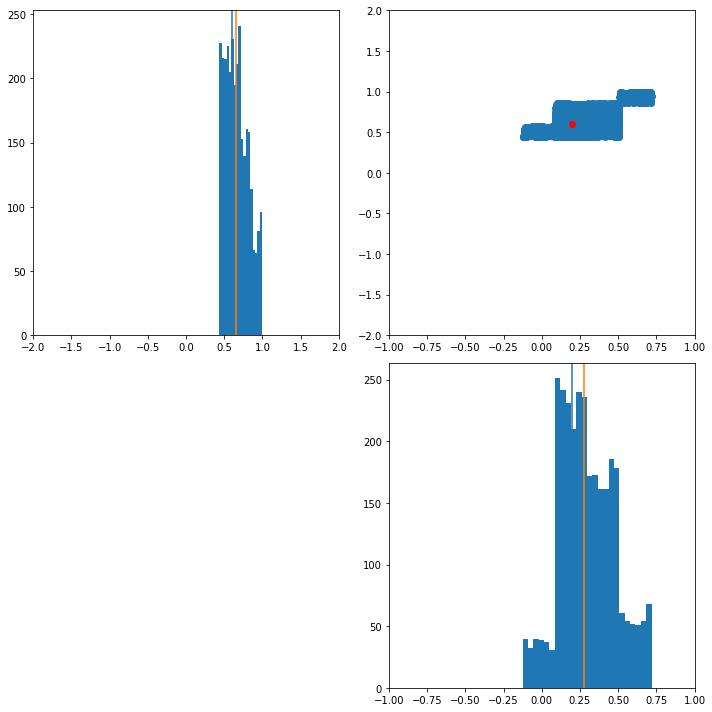

In [161]:
plot_posterior(post[-1])